# Lab-07-2 MNIST Introduction

* What is MNIST?
* Code: MNIST Classifier

## What is MNIST?
MNIST: handwritten digits dataset

training set images 60000장, test set images 10000장.

src: http://yann.lecun.com/exdb/mnist

## Example of MNIST

- 28 x 28 image
- 1 channel gray image
- 0 ~ 9 digits

In [ ]:
for X, Y in data_loader:
    # reshape input image into [batch_size by 784]
    # label is not one-hot encoded
    X = X.view(-1, 28 * 28)

## torchvision
The <u>torchvision</u> package consists of <u>popular datasets</u>, <u>model architectures</u>, and <u>common image transformations</u> for computer vision.

- torchvision.datasets
    - MNIST, Fashion-MNIST, EMNIST, COCO, LSUN, ...
- torchvision.models
    - Alexnet, AGG, ResNet, SqueezeNet, DenseNet, Inception v3
- torchvision.transforms
    - Transforms on PIL Image, Transforms on torch.*Tensor, Conversion Transforms, ...
- torchvision.utils

*(reference: https://pytorch.org/docs/stable/torchvision/index.html)*

In [2]:
pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Reading data

- torchvision.datasets.MNIST 인자 설명
    - root: 어느 경로에 MNIST 데이터가 있느냐?
    - train: True면 MNIST에 있는 train set, False로 하면 test set을 불러오기.
    - transform: MNIST를 불러올 때 어떤 transform을 적용할 거냐?
        - 일반적으로 PyTorch의 경우, 이미지는 0-1 사이의 값을 갖게 되고, 순서는 채널, 높이, 너비. ([C, H, W])
        - 일반적인 이미지는, 0-255, H, W, C 순서로 되어 있음.
    - download: MNIST 데이터가 없으면 다운을 받겠다.

- torch.utils.data.Dataset 인자 설명
    - DataLoader: 어떤 데이터를 로드할 거냐?
    - batch_size: 이 mnist_train 이미지를 불러올 때, 몇 개씩 짤라서 불러올래? (여기선 100을 사용하겠다.)
    - shuffle: 60000장에서 우리가 100장씩 이미지를 불러올 때, 순서를 섞을지 있는 순서대로 불러 올지
    - drop_last: batch_size만큼 잘라서 불러올 때 맨 뒤에 숫자가 맞지 않게 남는 데이터들을 어떻게 할 것이냐?
    
for 문을 통해서 데이터를 불러 온다. X에는 MNIST 이미지, Y는 label (0-9)

view()를 이용해서 28*28을 784로 바꿔 준다.

처음 X는 (배치 사이즈 크기 B, 1 채널, 28 높이, 28 너비)로 불러오는데, view를 이용해서, (배치 사이즈 크기 B, 784)로 바꿔주게 됨.
이걸 다시 X에 저장해서 사용하게 됨.

In [22]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
...
mnist_train = dsets.MNIST(root="MNIST_data/", train=True, transform=transforms.ToTensor(), download=True)

mnist_test = dsets.MNIST(root="MNIST_data/", train=False, transform=transforms.ToTensor(), download=True)

data_loader = Dataset(DataLoader=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
...
for epoch in range(training_epochs):
    ...
    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # Label is not one-hot encoded
        X = X.view(-1, 28*28).to(device)

NameError: name 'batch_size' is not defined

## Epoch / Batch size / Iteration

In the neural network terminology:
- one **epoch** = one forward pass and one backward pass of *all* the training examples
- **batch size** = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
- number of **iterations** = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
    
**Example**: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.


- MNIST train set은 60,000장으로 구성되어 있는데, 이 이미지들 전체가 트레이닝에 사용되었으면 한 **epoch**가 돌았다고 표현한다.
- 근데 한 번에 돌리기엔 메모리 많이 필요하고, 속도도 오래 걸림. 그래서 잘라서 사용. 이 자르는 크기를 몇으로 할 거냐가 **batch size**
- **iteration**은 이 batch를 몇 번 학습에 사용을 했냐?


## Softmax Classifier

classifier를 학습하는 방법을 좀 더 자세히 알아보자.

In [26]:
# Lab 7 Learning rate and Evaluation
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
# parameters
training_epochs = 15
batch_size = 100

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [27]:
# MNIST data image of shape 28 * 28 = 784
linear = torch.nn.Linear(784, 10, bias=True).to(device)
    # linear layer 사용. 0-9니까 10. bias(파라미터 b)는 true

# parameters
training_epochs = 15
batch_size = 100
# define cost/lost & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
    # PyTorch에서는 CrossEntropyLoss가 Softmax를 자동으로 계산해 주기 때문에 Softmax를 별도로 선언하지 않겠다.

optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)
    # Stochastic gradient descent. linear의 파라미터(w, b), learning rate는 0.1

for epoch in range(training_epochs):
    # 15번 반복 학습
    avg_cost = 0
    total_batch = len(data_loader)
    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
            # view를 이용해서 (배치 사이즈, 28 * 28)로 변경해서 사용.
        optimizer.zero_grad()
        hypothesis = linear(X)
            # linear 레이어에 입력으로 집어 넣으면, classifier가 분류한 분류 결과를 얻을 수 있을 것.
        cost = criterion(hypothesis, Y)
            # 분류 결과와 실제 정답 레이블 Y를 갖고 cross entropy를 이용해서 cost를 구하기.
        cost.backward()
            # 구해진 cost로, backward를 이용해서 gradient를 계산하게 되고,
        optimizer.step()
            # 그 gradient를 가지고 업데이트를 진행하게 된다.
        avg_cost += cost / total_batch
        
    print("Epoch: ", "%04d" % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

Epoch:  0001 cost = 0.535150588
Epoch:  0002 cost = 0.359577775
Epoch:  0003 cost = 0.331264287
Epoch:  0004 cost = 0.316404670
Epoch:  0005 cost = 0.307107002
Epoch:  0006 cost = 0.300456554
Epoch:  0007 cost = 0.294933379
Epoch:  0008 cost = 0.290956199
Epoch:  0009 cost = 0.287074119
Epoch:  0010 cost = 0.284515619
Epoch:  0011 cost = 0.281914055
Epoch:  0012 cost = 0.279526919
Epoch:  0013 cost = 0.277636588
Epoch:  0014 cost = 0.275874794
Epoch:  0015 cost = 0.274422765


## Test

In [35]:
# Test the model using test sets
with torch.no_grad():
    # 이 범위 안에서는 grad 계산을 안 하겠다는 의미
    
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
        # argmax: 최댓값이 있는 인덱스를 찾을 때 사용. (특히 Softmax와 같은 상황에서)
    accuracy = correct_prediction.float().mean()
    print("Accuracy: ", accuracy.item())

Accuracy:  0.8883000016212463


## Visualization

Label:  3
Prediction:  3


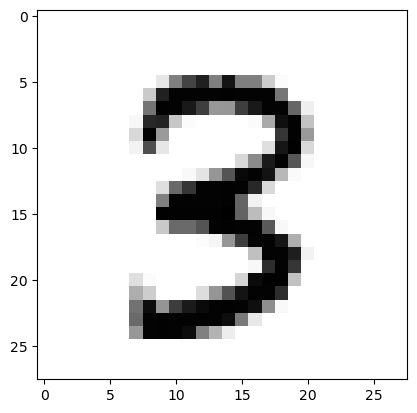

In [36]:
import matplotlib.pyplot as plt
import random

# Get one and predict
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print('Label: ', Y_single_data.item())
single_prediction = linear(X_single_data)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()